In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt
import optax

from flax import linen as nn
from flax.training import train_state
from jax import random
from jax import jacfwd

import sys
import os
import time

path_ = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if path_ not in sys.path:
    sys.path.append(path_)

from non_parametric_collocation import collocate_data
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
#from neural_net import create_train_state, train, neural_ode
from collocation import compute_weights, lagrange_derivative

In [2]:
#-----------------------------------------------DATA GENERATION-----------------------------------------------#
N = 10
noise_level = 0.0
ode_type = "decay"
params = {"c": 1}
start_time=0
end_time=5
spacing_type="chebyshev"
initial_state = 1.0

t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [3]:
jax.config.update("jax_enable_x64", True)

In [4]:
#-----------------------------------------------SIMPLE ODE DEF-----------------------------------------------#
def ode_func(t, u):
    # du_dt = -u
    return -u

#-----------------------------------------------L and L_prime-----------------------------------------------#
L = jnp.eye(N)
weights = compute_weights(t)
L_prime = lagrange_derivative(t, weights)

#-----------------------------------------------F(u) and G(u)-----------------------------------------------#
def RHS(u, t, L, ode_func):
    def F_i(i):
        sum_term = jnp.dot(u, L[i])  # Lagrange interpolation
        return ode_func(t[i], sum_term)
    
    F_vec = jax.vmap(F_i)(jnp.arange(N))
    return F_vec

def G(u, t, L, L_prime, RHS, ode_func):
    return jnp.dot(L_prime, u) - RHS(u, t, L, ode_func)

#-------------------------------------SOLVE USING OPTIMIZATION---------------------------------------------#
def loss_fn(u, t, L, L_prime, RHS, ode_func):
    G_val = G(u, t, L, L_prime, RHS, ode_func)
    return jnp.sum(G_val**2)

def optimize(u_init, t, L, L_prime, RHS, ode_func, learning_rate=1e-1, tol=1e-6, max_iter=10000):
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(u_init)

    @jax.jit
    def step(u, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(u, t, L, L_prime, RHS, ode_func)
        updates, opt_state = optimizer.update(grads, opt_state)
        u = optax.apply_updates(u, updates)
        return u, opt_state, loss

    u = u_init
    for i in range(max_iter):
        u, opt_state, loss = step(u, opt_state)
        if loss < tol:
            print(f"Converged at iteration {i+1} with loss {loss}")
            return u
    
    raise ValueError("Optimization did not converge")

# initial guess for u
u_init = jnp.ones(N)
u_init = u_init.at[0].set(1.0)  # initial condition u(0) = u0

t1 = time.time()
u_sol = optimize(u_init, t, L, L_prime, RHS, ode_func)
t2 = time.time()
print(f"Time elapsed: {t2 - t1}")

Converged at iteration 147 with loss 6.864333998697563e-07
Time elapsed: 0.04830288887023926


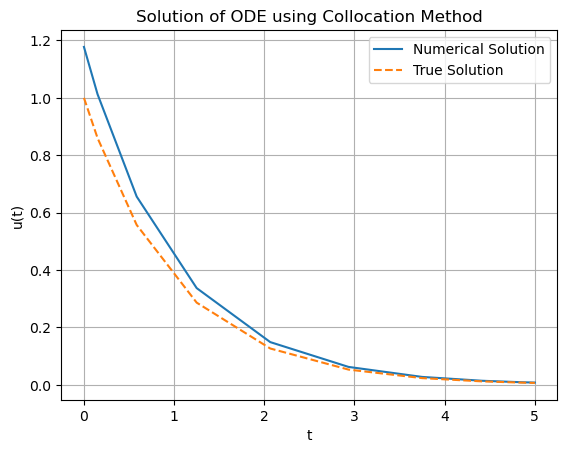

In [5]:
# Plot the solution
plt.plot(t, u_sol, label='Numerical Solution')
plt.plot(t, y, "--", label='True Solution')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()

In [6]:
#-----------------------------------------------DATA GENERATION-----------------------------------------------#
N = 25
noise_level = 0.2
ode_type = "harmonic_oscillator"
params = {"omega_squared": 1}
start_time=0
end_time=10
spacing_type="chebyshev"
initial_state = jnp.array([1.0, 0.0])

t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

In [7]:
#-----------------------------------------------ODE DEF 2 STATE VAR-----------------------------------------------#
def ode_func2(t, uv, omega_squared):
    u, v = uv
    du_dt = v
    dv_dt = -omega_squared * u
    return jnp.array([du_dt, dv_dt])

#-----------------------------------------------L and L_prime-----------------------------------------------#
L = jnp.eye(N)
weights = compute_weights(t)
L_prime = lagrange_derivative(t, weights)
omega = params['omega_squared']

#-----------------------------------------------F(u) and G(u)-----------------------------------------------#
def RHS(u, t, L, ode_func, omega):
    def F_i(i):
        sum_term = jnp.dot(L[i], u)  # Lagrange interpolation
        return ode_func(t[i], sum_term, omega)
    
    F_vec = jax.vmap(F_i)(jnp.arange(N))
    return F_vec

def G(u, t, L, L_prime, RHS, ode_func, omega):
    return jnp.dot(L_prime, u) - RHS(u, t, L, ode_func, omega)

#-------------------------------------SOLVE USING OPTIMIZATION---------------------------------------------#
def loss_fn(u, t, L, L_prime, RHS, ode_func, omega, u_init):
    # include the initial conditions
    u_full = jnp.vstack([u_init[0:1], u])  
    # form the residual vector
    G_val = G(u_full, t, L, L_prime, RHS, ode_func, omega)
    # exclude the initial conditions 
    return G_val[1:].flatten()  

def newton_solve(u_init, t, L, L_prime, RHS, ode_func, omega, tol=1e-6, max_iter=100):
    # exclude the initial conditions 
    u = u_init[1:]  

    for i in range(max_iter):
        # obtain the residual vector
        G_val = loss_fn(u, t, L, L_prime, RHS, ode_func, omega, u_init)
        # Jacobian matrix
        J = jacfwd(loss_fn, argnums=0)(u, t, L, L_prime, RHS, ode_func, omega, u_init)
        
        # reshape Jacobian to match the dimensions required for solving the linear system
        J = J.reshape((-1, (N-1) * 2))  
        G_val = G_val.reshape((-1, 1)) 

        # compute the update step delta_u
        delta_u = jnp.linalg.solve(J, -G_val).reshape(u.shape)
        u = u + delta_u
        
        if jnp.linalg.norm(delta_u) < tol:
            print(f"Converged at iteration {i+1} with step norm {jnp.linalg.norm(delta_u)}")
            return jnp.vstack([u_init[0:1], u])  # Reinsert the fixed initial value
    
    raise ValueError("Newton's method did not converge")

In [8]:
# initial guess for u
u_init = jnp.ones((N, 2))
u_init = u_init.at[0, 0].set(1.0)
u_init = u_init.at[0, 1].set(0.0)  

t1 = time.time()
sol_coll = newton_solve(u_init, t, L, L_prime, RHS, ode_func2, omega)
t2 = time.time()
print(f"Time elapsed: {t2 - t1}")

Converged at iteration 2 with step norm 1.0837933757262593e-14
Time elapsed: 0.5103013515472412


In [9]:
t_full, y_full, _, _ = generate_ode_data(100, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

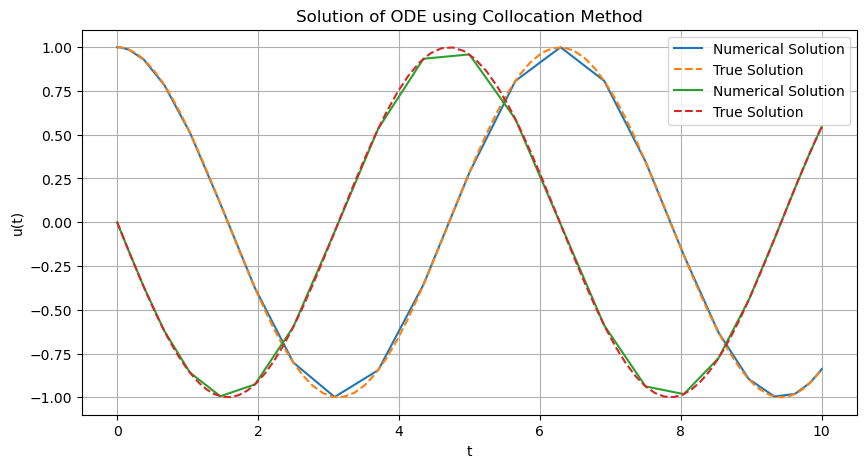

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(t, sol_coll.T[0], label='Numerical Solution')
plt.plot(t_full, y_full.T[0], "--", label='True Solution')
plt.plot(t, sol_coll.T[1], label='Numerical Solution')
plt.plot(t_full, y_full.T[1], "--", label='True Solution')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()

### odeint comparison

In [11]:
def ode_func2_odeint(y, t, omega):
    # simple harmonic oscillator in the format needed for odeint
    dydt = jnp.array([y[1], -omega**2 * y[0]])
    return dydt

t1 = time.time()
sol_odeint = odeint(ode_func2_odeint, jnp.array([1.0, 0.0]), t, 1.0)
t2 = time.time()
print(f"Time elapsed: {t2 - t1}")

Time elapsed: 0.14843177795410156


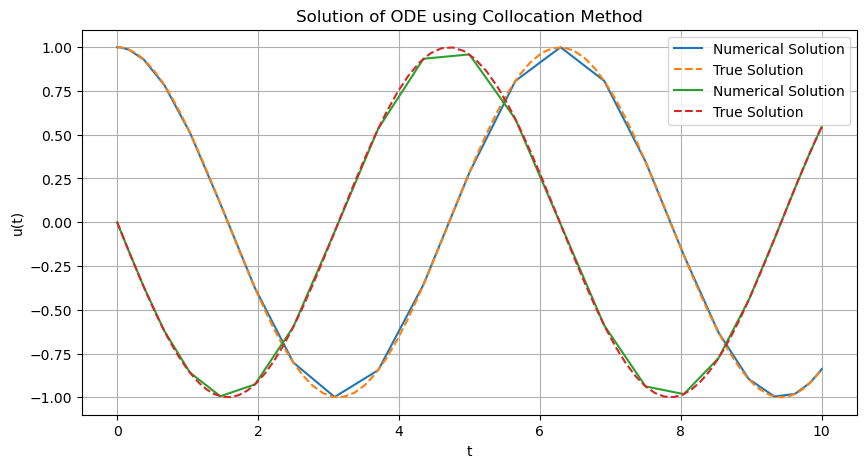

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(t, sol_odeint.T[0], label='Numerical Solution')
plt.plot(t_full, y_full.T[0], "--", label='True Solution')
plt.plot(t, sol_odeint.T[1], label='Numerical Solution')
plt.plot(t_full, y_full.T[1], "--", label='True Solution')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Solution of ODE using Collocation Method')
plt.legend()
plt.grid()
plt.show()